# Generative Adversarial Nets

[Paper here](https://arxiv.org/pdf/1406.2661)


In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Hyperparameters

BATCH_SIZE = 100
N_EPOCHS = 100
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

## Load the dataset

In [4]:
train_dataset = MNIST(
    root="./data/", download=True, train=True, transform=transforms.ToTensor()
)
test_dataset = MNIST(
    root="./data/", download=True, train=False, transform=transforms.ToTensor()
)


In [5]:
mean_pixel_train = train_dataset.data.float().mean() / 255
std_pixel_train = train_dataset.data.float().std() / 255

mean_pixel_test = test_dataset.data.float().mean() / 255
std_pixel_test = test_dataset.data.float().std() / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)

((tensor(0.1307), tensor(0.3081)), (tensor(0.1325), tensor(0.3105)))

In [6]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_test, std_pixel_test),
    ]
)


In [7]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * std_pixel + mean_pixel

    x = transforms.ToPILImage()(x)

    return x

In [8]:
full_train_dataset = MNIST(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = MNIST(
    root="./data/", download=True, train=False, transform=test_transform
)

In [9]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [11]:
len(train_loader), len(val_loader), len(test_loader)

(420, 180, 100)

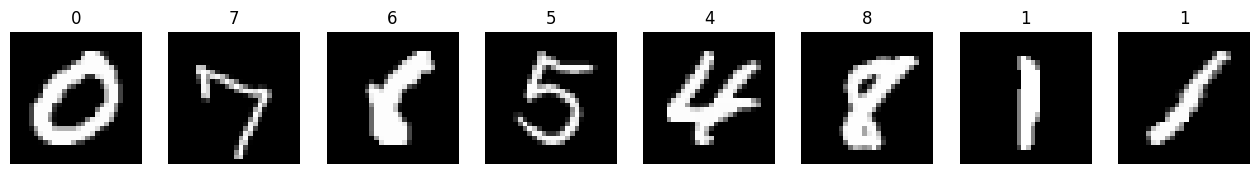

In [12]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(label)
    axs[i].axis("off")

plt.show()


## Build the architecture

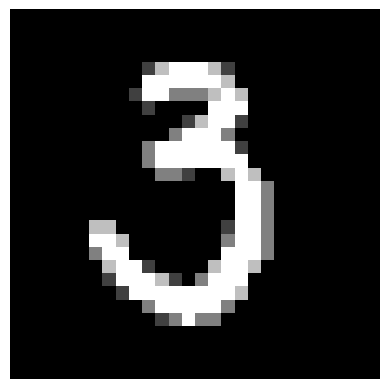

torch.Size([1, 28, 28])

3

In [13]:
sample_image, sample_label = train_loader.dataset[40]
plt.imshow(reverse_transform(sample_image, train=True), cmap="gray")
plt.axis("off")
plt.show()

print(sample_image.shape)
print(sample_label)


In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_shape, debug=False):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.image_shape = image_shape

        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh(),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[GENERATOR] Input")
        x = self.gen(x)
        self._debug_print(x, "[GENERATOR] Output")
        x = x.view(x.size(0), *self.image_shape)
        self._debug_print(x, "[GENERATOR] Reshaped Output")

        return x

[GENERATOR] Input: torch.Size([8, 128])

[GENERATOR] Output: torch.Size([8, 784])

[GENERATOR] Reshaped Output: torch.Size([8, 1, 28, 28])

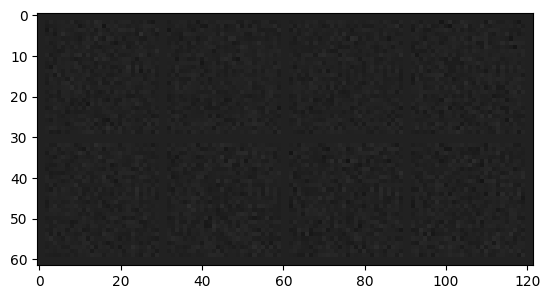

In [15]:
g = Generator(128, sample_image.shape, debug=True)

plt.imshow(reverse_transform(make_grid(g(torch.randn(8, 128)), nrow=4)), cmap="gray")

In [16]:
class Discriminator(nn.Module):
    def __init__(self, image_shape, debug=False):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(int(np.prod(image_shape)), 1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[DISCRIMINATOR] Input")
        x = x.view(x.size(0), -1)
        self._debug_print(x, "[DISCRIMINATOR] Reshaped Input")
        x = self.layer(x)
        self._debug_print(x, "[DISCRIMINATOR] Output")
        return x

In [17]:
Discriminator(sample_image.shape, debug=True)(train_dataset[0][0].unsqueeze(0))

[DISCRIMINATOR] Input: torch.Size([1, 1, 28, 28])

[DISCRIMINATOR] Reshaped Input: torch.Size([1, 784])

[DISCRIMINATOR] Output: torch.Size([1, 1])

tensor([[0.5231]], grad_fn=<SigmoidBackward0>)

In [18]:
g = Generator(latent_dim=128, image_shape=sample_image.shape)
d = Discriminator(image_shape=sample_image.shape)

loss_fn = nn.BCELoss()

g_optimizer = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE)
d_optimizer = torch.optim.Adam(d.parameters(), lr=LEARNING_RATE)

print(
    f"Total number of parameters in both models: {sum(p.numel() for p in g.parameters()) + sum(p.numel() for p in d.parameters())}"
)


Total number of parameters in both models: 2953745

In [19]:
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    g_train_loss = 0.0
    d_train_loss = 0.0

    for idx, (imgs, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
        batch_size = imgs.size(0)

        ## Train Discriminator
        noise = torch.randn(batch_size, g.latent_dim)
        fake_imgs = g(noise)

        real_loss = loss_fn(d(imgs), torch.ones(batch_size, 1))
        fake_loss = loss_fn(d(fake_imgs), torch.zeros(batch_size, 1))

        d_loss = (real_loss + fake_loss) / 2
        d_train_loss += d_loss.item()

        d_optimizer.zero_grad()
        d_loss.backward(retain_graph=True)
        d_optimizer.step()

        ## Train Generator
        g_loss = loss_fn(d(fake_imgs), torch.ones(batch_size, 1))
        g_train_loss += g_loss.item()

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    g_train_loss /= len(train_loader)
    d_train_loss /= len(train_loader)

    print(f"Epoch: {epoch} | G Loss: {g_train_loss:.4f} | D Loss: {d_train_loss:.4f}")


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 0 | G Loss: 1.3380 | D Loss: 0.4597

Training Epoch 1:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 1 | G Loss: 2.9775 | D Loss: 0.2156

Training Epoch 2:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 2 | G Loss: 5.7117 | D Loss: 0.1333

Training Epoch 3:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 3 | G Loss: 5.3601 | D Loss: 0.0559

Training Epoch 4:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 4 | G Loss: 6.0832 | D Loss: 0.0557

Training Epoch 5:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 5 | G Loss: 6.6730 | D Loss: 0.0471

Training Epoch 6:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 6 | G Loss: 6.8490 | D Loss: 0.0299

Training Epoch 7:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 7 | G Loss: 7.5166 | D Loss: 0.0340

Training Epoch 8:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 8 | G Loss: 7.4953 | D Loss: 0.0274

Training Epoch 9:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 9 | G Loss: 8.2599 | D Loss: 0.0218

Training Epoch 10:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 10 | G Loss: 8.4812 | D Loss: 0.0215

Training Epoch 11:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 11 | G Loss: 8.1561 | D Loss: 0.0190

Training Epoch 12:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 12 | G Loss: 8.7152 | D Loss: 0.0230

Training Epoch 13:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 13 | G Loss: 7.6855 | D Loss: 0.0241

Training Epoch 14:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 14 | G Loss: 8.4012 | D Loss: 0.0178

Training Epoch 15:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 15 | G Loss: 8.4131 | D Loss: 0.0182

Training Epoch 16:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 16 | G Loss: 8.0788 | D Loss: 0.0249

Training Epoch 17:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 17 | G Loss: 7.5654 | D Loss: 0.0218

Training Epoch 18:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 18 | G Loss: 7.8551 | D Loss: 0.0211

Training Epoch 19:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 19 | G Loss: 7.6218 | D Loss: 0.0201

Training Epoch 20:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 20 | G Loss: 8.1951 | D Loss: 0.0209

Training Epoch 21:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 21 | G Loss: 7.3463 | D Loss: 0.0214

Training Epoch 22:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 22 | G Loss: 7.4121 | D Loss: 0.0231

Training Epoch 23:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 23 | G Loss: 7.5383 | D Loss: 0.0185

Training Epoch 24:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 24 | G Loss: 7.7778 | D Loss: 0.0190

Training Epoch 25:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 25 | G Loss: 7.6674 | D Loss: 0.0199

Training Epoch 26:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 26 | G Loss: 7.4790 | D Loss: 0.0192

Training Epoch 27:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 27 | G Loss: 7.3479 | D Loss: 0.0185

Training Epoch 28:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 28 | G Loss: 7.3779 | D Loss: 0.0190

Training Epoch 29:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 29 | G Loss: 7.2258 | D Loss: 0.0180

Training Epoch 30:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 30 | G Loss: 7.4604 | D Loss: 0.0183

Training Epoch 31:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 31 | G Loss: 7.3604 | D Loss: 0.0167

Training Epoch 32:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 32 | G Loss: 7.5445 | D Loss: 0.0154

Training Epoch 33:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 33 | G Loss: 7.6234 | D Loss: 0.0167

Training Epoch 34:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 34 | G Loss: 7.5832 | D Loss: 0.0162

Training Epoch 35:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 35 | G Loss: 7.6947 | D Loss: 0.0156

Training Epoch 36:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 36 | G Loss: 7.8667 | D Loss: 0.0132

Training Epoch 37:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 37 | G Loss: 7.8850 | D Loss: 0.0145

Training Epoch 38:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 38 | G Loss: 7.9473 | D Loss: 0.0124

Training Epoch 39:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 39 | G Loss: 7.9058 | D Loss: 0.0135

Training Epoch 40:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 40 | G Loss: 7.9039 | D Loss: 0.0141

Training Epoch 41:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 41 | G Loss: 8.0038 | D Loss: 0.0117

Training Epoch 42:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 42 | G Loss: 8.0236 | D Loss: 0.0129

Training Epoch 43:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 43 | G Loss: 7.7997 | D Loss: 0.0126

Training Epoch 44:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 44 | G Loss: 7.9885 | D Loss: 0.0106

Training Epoch 45:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 45 | G Loss: 8.1920 | D Loss: 0.0113

Training Epoch 46:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 46 | G Loss: 8.0009 | D Loss: 0.0107

Training Epoch 47:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 47 | G Loss: 8.4185 | D Loss: 0.0099

Training Epoch 48:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 48 | G Loss: 8.2585 | D Loss: 0.0108

Training Epoch 49:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 49 | G Loss: 8.3123 | D Loss: 0.0094

Training Epoch 50:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 50 | G Loss: 8.4341 | D Loss: 0.0095

Training Epoch 51:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch: 51 | G Loss: 8.5105 | D Loss: 0.0090

Training Epoch 52:   0%|          | 0/420 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:22                                                                                   │
│                                                                                                  │
│   19 │   │   d_train_loss += d_loss.item()                                                       │
│   20 │   │                                                                                       │
│   21 │   │   d_optimizer.zero_grad()                                                             │
│ ❱ 22 │   │   d_loss.backward(retain_graph=True)                                                  │
│   23 │   │   d_optimizer.step()                                                                  │
│   24 │   │                                                                                       │
│   25 │   │   ## Train Generator                                                                  │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\_tensor.py:525 in backward       │
│                                                                                                  │
│    522 │   │   │   │   create_graph=create_graph,                                                │
│    523 │   │   │   │   inputs=inputs,                                                            │
│    524 │   │   │   )                                                                             │
│ ❱  525 │   │   torch.autograd.backward(                                                          │
│    526 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    527 │   │   )                                                                                 │
│    528                                                                                           │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\autograd\__init__.py:267 in      │
│ backward                                                                                         │
│                                                                                                  │
│   264 │   # The reason we repeat the same comment below is that                                  │
│   265 │   # some Python versions print out the first line of a multi-line function               │
│   266 │   # calls in the traceback and some print out the last line                              │
│ ❱ 267 │   _engine_run_backward(                                                                  │
│   268 │   │   tensors,                                                                           │
│   269 │   │   grad_tensors_,                                                                     │
│   270 │   │   retain_graph,                                                                      │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\autograd\graph.py:744 in         │
│ _engine_run_backward                                                                             │
│                                                                                                  │
│   741 │   if attach_logging_hooks:                                                               │
│   742 │   │   unregister_hooks = _register_logging_hooks_on_whole_graph(t_outputs)               │
│   743 │   try:                                                                                   │
│ ❱ 744 │   │   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to    │
│   745 │   │   │   t_outputs, *args, **kwargs               

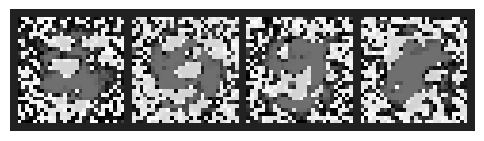

In [20]:
g.eval()
d.eval()

plt.figure(figsize=(6, 6))
plt.imshow(reverse_transform(make_grid(g(torch.randn(4, g.latent_dim)), nrow=4)))
plt.axis("off")
plt.show()
